In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext Cython

In [2]:
def analyze(x, y, log=False):
    fig, ax = plt.subplots(3)
    nm = max(1, len(x)//1000)
    ax[0].plot(x[::nm], "c-.", label="input")
    ax[0].plot(y[::nm], "r-", label="output")
    ax[0].legend(loc="right")
    ax[0].set_xlabel("time (1/fs)")
    ax[0].set_ylabel("signal")
    x = x - np.mean(x)
    y = y - np.mean(y)
    n = len(x)//max(1, len(x)//(1<<20))
    w = np.hanning(n)
    x = (x.reshape(-1, n)*w).sum(0)
    y = (y.reshape(-1, n)*w).sum(0)
    t = (np.fft.rfft(y)/np.fft.rfft(x))
    f = np.fft.rfftfreq(n)
    fmin = f[1]
    ax[1].plot(f,  20*np.log10(np.abs(t)), "r-")
    # ax[1].set_ylim(-70, 3)
    ax[1].set_xlim(fmin, .5)
    if log:
        ax[1].set_xscale("log")
    ax[1].set_xlabel("frequency (fs)")
    ax[1].set_ylabel("magnitude (dB)")
    ax[1].grid(True)
    ax[2].plot(f,  np.rad2deg(np.angle(t)), "r-")
    ax[2].set_xlim(fmin, .5)
    if log:
        ax[2].set_xscale("log")
    ax[2].set_xlabel("frequency (fs)")
    ax[2].set_ylabel("phase (deg)")
    ax[2].grid(True)
    return fig


def f2i(f, width, shift):
    i = int(round(f*(1 << shift)))
    k = 1 << width - 1
    assert -k <= i <= k - 1, (f, width, shift, hex(i), hex(k))
    return i


def pi_iir(c, s, f, k, g=np.inf):
    # transfer function: H(s) = k*(s/(2*pi*f) + 1)/(s/(2*pi*f) + 1/g)
    # g=inf, H(s) = k*(s/w + 1)/(s/w) = k*(1 + w/s) = k + k*2*pi*f/s
    # f: integrator corner a.k.a. P zero (in units of fs)
    # k: P gain
    # g: I gain limit

    # H1(s) = k + m/s
    # k [2e-2, 2e1]
    # f [2e-2, 2e-1]
    # m=k*2*pi*f [1e-3, 1e1]
    f *= np.pi
    z = f/g + 1
    a1 = f2i((f/g - 1)/z, c, s)
    b0 = f2i(k*(f + 1)/z, c - 1, s)  # pre-adder
    b1 = f2i(k*(f - 1)/z, c - 1, s)  # pre-adder
    # assert b0 != -b1, "b collapse {}/{}".format(b0, b1)
    return a1, b0, b1

def iir(b, a, x, y):
    n = len(b) - 1
    assert n >= 0
    for i in range(n, len(x)):
        y[i] = ((x[i - n:i + 1]*b).sum() - (y[i - n:i]*a[:-1]).sum())//a[-1]

def uni(n, v, seed=1):
    if seed is not None:
        np.random.seed(seed)
    return np.trunc(np.random.uniform(-v, v, n)).astype(np.int64)

In [3]:
%%cython

from __future__ import division
cimport cython
import numpy as np
cimport numpy as np
DTYPE = np.int
ctypedef np.int_t DTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
def ciir(object[DTYPE_t, ndim=1] b, object[DTYPE_t, ndim=1] a,
         object[DTYPE_t, ndim=1] x, object[DTYPE_t, ndim=1] y):
    cdef int n = b.shape[0] - 1, i, j, k
    cdef DTYPE_t yi
    for i in range(n, x.shape[0]):
        yi = x[i]*b[n]
        for j in range(n):
            k = i - n + j
            yi += x[k]*b[j] - y[k]*a[j]
        y[i] = yi//a[n]

[-20  21] [-2048  2048]


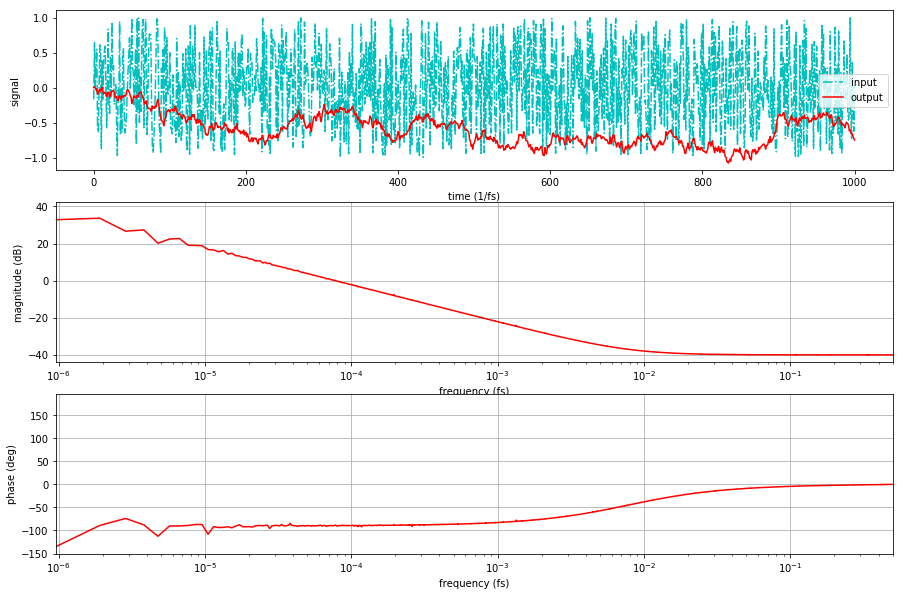

In [4]:
s, c, h = 25, 18, 11
g = np.inf
#f, k = .01, 31
#f, k = .0001, 1.
#f, k = .1, 1.
#f, k = .0005, .1
f, k = .005, .01
#f, k = .05, .002
#f, k = .3, .0002
a1, b0, b1 = pi_iir(c, h, f, k, g)
b, a = np.array([b1, b0]), np.array([a1, 1<<h])
print(b, a)

x = uni(1<<24, 1<<s-2)  # pre-adder
y = np.empty_like(x)
y[:len(a) - 1] = 0
ciir(b, a, x, y)
fig = analyze(x/(1<<s-2), y/(1<<s-2), log=True)
fig.set_size_inches(15, 10)

In [5]:
x = x[:1<<16]
%timeit iir(b, a, x, y)
%timeit ciir(b, a, x, y)

1 loop, best of 3: 273 ms per loop
1000 loops, best of 3: 872 µs per loop
